In [20]:
# 0. 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pickle

In [21]:
# 1. 데이터 불러오기 및 기본 전처리
df = pd.read_csv("./Data/Dummy_02.csv")
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['epc_code', 'product_serial', 'event_time'])
print('데이터 샘플:')
display(df.head(5))

데이터 샘플:


,epc_code,product_serial,product_name,hub_type,event_type,event_time
0,001.8805843.584374.000000001,1,Product 1,Yeongju,commissioning,2025-01-21 17:54:00
1,001.8805843.584374.000000001,1,Product 1,Yeongju,aggregation,2025-01-21 18:15:00
2,001.8805843.584374.000000001,1,Product 1,Yeongju,WMS_inbound,2025-01-21 18:55:00
3,001.8805843.584374.000000001,1,Product 1,Yeongju,WMS_outbound,2025-01-25 07:35:00
4,001.8805843.584374.000000001,1,Product 1,Busan,stock_inbound(HUB),2025-01-25 10:51:00


In [22]:
# 2. 시간 정보 처리
df['time_delta'] = df.groupby(['epc_code', 'product_serial'])['event_time'] \
                      .transform(lambda x: (x - x.min()).dt.total_seconds())

In [23]:
# 3. 변수 인코딩
le_event = LabelEncoder()
df['event_type_enc'] = le_event.fit_transform(df['event_type'])

le_hub = LabelEncoder()
df['hub_type_enc'] = le_hub.fit_transform(df['hub_type'])

scaler = MinMaxScaler()
df['time_delta_scaled'] = scaler.fit_transform(df[['time_delta']])

print('전처리 후 데이터 샘플:')
display(df[['epc_code', 'product_serial', 'event_time', 'time_delta', 
          'event_type', 'event_type_enc', 'hub_type', 'hub_type_enc', 'time_delta_scaled']].head(10))

전처리 후 데이터 샘플:


,epc_code,product_serial,event_time,time_delta,event_type,event_type_enc,hub_type,hub_type_enc,time_delta_scaled
0,001.8805843.584374.000000001,1,2025-01-21 17:54:00,0.0,commissioning,3,Yeongju,5,0.000000
1,001.8805843.584374.000000001,1,2025-01-21 18:15:00,1260.0,aggregation,2,Yeongju,5,0.000105
2,001.8805843.584374.000000001,1,2025-01-21 18:55:00,3660.0,WMS_inbound,0,Yeongju,5,0.000304
3,001.8805843.584374.000000001,1,2025-01-25 07:35:00,308460.0,WMS_outbound,1,Yeongju,5,0.025655
4,001.8805843.584374.000000001,1,2025-01-25 10:51:00,320220.0,stock_inbound(HUB),4,Busan,0,0.026633
5,001.8805843.584374.000000001,1,2025-03-02 04:15:00,3406860.0,stock_outbound(HUB),7,Busan,0,0.283357
6,001.8805843.584374.000000001,1,2025-03-02 12:21:00,3436020.0,stock_inbound(Wholesaler),6,Busan,0,0.285782
7,001.8805843.584374.000000001,1,2025-03-28 03:16:00,5649720.0,stock_outbound(Wholesaler),9,Busan,0,0.469901
8,001.8805843.584374.000000001,1,2025-03-28 07:33:00,5665140.0,stock_inbound(Reseller),5,Busan,0,0.471183
9,001.8805843.584374.000000001,1,2025-04-17 14:25:00,7417860.0,stock_outbound(Sell),8,Busan,0,0.616961


In [24]:
# 4. One-Class XGBoost 적용 (이상 탐지 라벨 없이 정상 데이터만 학습)
feature_columns = ['event_type_enc', 'hub_type_enc', 'time_delta_scaled']
X = df[feature_columns]

# 정상 데이터만 사용 (라벨이 없으므로 모든 데이터를 정상으로 가정)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [25]:
# 5. XGBoost 회귀 모델 학습 (이상 탐지 스코어 기반)
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, X_train)  # 자기 자신을 예측하도록 학습

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
# 6. 이상 탐지 점수 계산 (재구성 오차 기반)
X_pred = xgb_model.predict(X_test)
anomaly_scores = np.abs(X_test.values - X_pred)
thresh = np.mean(anomaly_scores) + 3 * np.std(anomaly_scores)
anomalies = (anomaly_scores > thresh).any(axis=1)

탐지된 이상치 개수: 243
총 샘플 수: 22206
이상치 비율: 1.09%


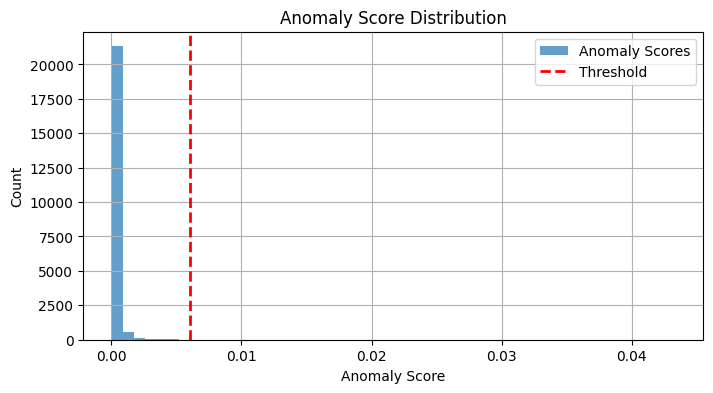

In [27]:
# 7. 이상 탐지 결과 확인
anomaly_counts = np.sum(anomalies)
total_samples = len(X_test)
anomaly_ratio = anomaly_counts / total_samples * 100
print(f"탐지된 이상치 개수: {anomaly_counts}")
print(f"총 샘플 수: {total_samples}")
print(f"이상치 비율: {anomaly_ratio:.2f}%")

# 이상 탐지 시각화
plt.figure(figsize=(8, 4))
plt.hist(anomaly_scores.mean(axis=1), bins=50, alpha=0.7, label='Anomaly Scores')
plt.axvline(thresh, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.title('Anomaly Score Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# # 9. 학습 후 최종 모델 평가 시, 전체 데이터에 대한 재구성 오차와 임계치를 계산
# X_pred = autoencoder.predict(X)
# reconstruction_errors = np.mean(np.square(X_pred - X), axis=(1,2))
# final_threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
# print("최종 임계치:", final_threshold)

# # 모델 저장
# autoencoder.save('autoencoder_model.h5')

# # 임계치 저장
# with open('threshold.pkl', 'wb') as f:
#     pickle.dump(final_threshold, f)

# # LabelEncoder 저장
# with open('event_type_encoder.pkl', 'wb') as f:
#     pickle.dump(le_event, f)

# with open('hub_type_encoder.pkl', 'wb') as f:
#     pickle.dump(le_hub, f)
    
# MinMaxScaler 저장
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)